In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from graphing_utils import *
import sys

device = "cuda" if torch.cuda.is_available() else "cpu"

class SI_fully_mixed:
    def __init__(self,n,seed=[0],pcon=0.01,pinf=0.1):
        self._S = torch.ones((n,1),device=device)
        self._I = torch.zeros((n,1),device=device)
        self._S[0,seed]=0
        self._I[0,seed]=1
        self._con = (-torch.eye(n,device=device)+1)*pcon
        self._pinf = pinf
        self._n = n
        
        self._i = 0
        self._stats = []
    
    def step(self):
        dI = torch.mm(self._I,self._con)*self._pinf
        dI = (torch.rand(self._n,device=device)<dI).float()
        self._I = torch.max(self._I,dI)
        self._S -= dI
        self._S = F.relu(self._S)
        
        self._i+=1
        self._stats.append((self._S.sum(),self._I.sum()))
        
        return self._stats[self._i-1]

class SI_erdos_renyi(torch.nn.Module):
    #child class of torch.nn.Module
    def __init__(self,pinf=0.1, contact_net=None, maxt=150):
        super(SI_erdos_renyi, self).__init__()
        self._contact_net = contact_net
        self._pinf = pinf
        self._maxt = maxt
        #number of whole people
        self._n = self._contact_net.size()[0]
        
    def step(self, population):      
        S,I = population
        I = I.unsqueeze(dim=1)
        #dI= A*I, a people contact with dI infected people 
        dI = self._contact_net.mm(I)
        I = I.squeeze()
        dI = dI.squeeze()
        #dI= A*I*pinf
        dI = dI*self._pinf
        #uniform distribution random on the interval (0,1), similar with sample operation
        dI = torch.rand(self._n).to(device)<dI
        dI = dI.float()
        #I= I+dI
        I = torch.max(I,dI)
        #S= S-dI
        S -= dI
        #keep the numerical stable ?
        S = F.relu(S)
        return torch.stack((S,I))
    #also () method
    def forward(self, population):
        log = []
        for i in range(self._maxt):
            #simulate one time
            population = self.step(population)
            log.append(torch.stack((
            population[0],
            population[1]
            )))
        log = torch.stack(log)
        return log

In [2]:
'''
Equal to create ER random network with 3 edges per node
'''
n=1000000
#memory usage: 2000000*4/1024/1024*3 aprox equal 22.8MB
#n is contact number (edge number)
m = 3*n
#every 1 cost 30 MB, base 26MB, initial 568MB
#create a 2*m random integer matrix, smaller than n, edge pair relation
idx = torch.randint(n,(2,m))
#create n*n adjacency contact matrix, 2000000*2000000, float32
#s list, t list, value list
con = torch.sparse.FloatTensor(idx,torch.ones(m),torch.Size([n,n])).to(device)

In [3]:
def sim(con, pinf=0.1, maxt=150, repeats=1):
    S = torch.ones(n).to(device)
    I = torch.zeros(n).to(device)
    #let first people infected
    S[0] = 0
    I[0] = 1
    #pack
    population = torch.stack((S,I))
    
    with torch.no_grad():
        #create class
        si = SI_erdos_renyi(contact_net=con, pinf=pinf, maxt=maxt).to(device)
        #si() run maxt times
        log = [si(population) for i in range(repeats)]
        log = torch.stack(log)
    return log

In [8]:
T = time.time()
log = sim(con)
print(time.time()-T)

1.339158535003662


In [11]:
3484-626

2858

In [12]:
print(log.size())
print(sys.getsizeof(log.storage()))
1*150*2*1000000/1024/1024


torch.Size([1, 150, 2, 1000000])
300000048


286.102294921875

In [7]:
#log, 1, 150, 2, 2000000, bool/float 32
del log
torch.cuda.empty_cache()

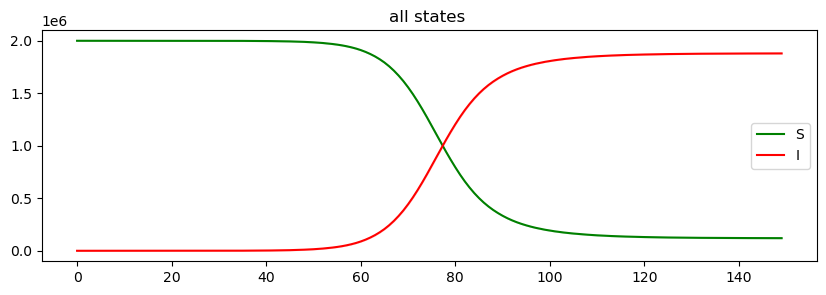

In [7]:
colors = [("green","S"), ("red","I")]
age_sizes = [n]
plot(log, colors, age_sizes, by_age=False)